In [4]:
import pandas as pd
import numpy as np
import time
from google.colab import userdata

In [5]:
issue_data = pd.read_csv('/content/IssueDetails.csv')
issue_data.head()

,IssueID,Title,Body
0,43173,spider doing I/O inside the event loop,<!-- READ THIS FIRST:\r\n - If you need addit...
1,43055,Unable to bind to gree device,## The problem\r\nUnable to bind to gree devic...
2,43029,Notion battery sensors showing “unavailable” a...,<!-- READ THIS FIRST:\n - If you need additio...
3,42950,[asyncio] socket.send() raised exception. Cras...,<!-- READ THIS FIRST:\r\n - If you need addit...
4,42947,Nest (SDM) Google Pubsub stops working after 6...,<!-- READ THIS FIRST:\r\n - If you need addit...


In [6]:
len(issue_data)

330

In [7]:
classify_data = pd.read_csv('/content/BugSet.csv')
classify_data.head()

,Issue ID,Integration,Taxonomy,Root Cause,Fix,Impact,Trigger,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,43173.0,spider,Initialization,Incorrect task scheduling,Remove the heavy task from the event loop.,Slow response,Invoke device service,NaN,NaN,NaN
1,43055.0,gree,Discovery,Generate incorrect device information,Generate unique device id,Device unavailable,Loading device integration,NaN,NaN,NaN
2,43029.0,notion,Others,API-update-caused breakage,Fix API usage.,Device unavailable,,NaN,NaN,NaN
3,42950.0,dsmr,Device,Device failure,Use new device instead,Device unavailable,Frequent requests,NaN,NaN,NaN
4,42947.0,nest,Initialization,Forget to keep authentication,Add watchdog or set timer function to maintain...,Device unavailable,Loading device integration,NaN,NaN,NaN


In [8]:
len(classify_data)

336

In [9]:
classify_data['IssueID'] = issue_data['IssueID'].astype(float)

# Merge the dataframes
merged_df = pd.merge(
    issue_data,
    classify_data,
    left_on='IssueID',
    right_on='Issue ID',
    how='inner'
)


In [10]:
merged_df = merged_df.drop('IssueID_x', axis=1)

In [11]:
merged_df.head()

,Title,Body,Issue ID,Integration,Taxonomy,Root Cause,Fix,Impact,Trigger,Unnamed: 7,Unnamed: 8,Unnamed: 9,IssueID_y
0,spider doing I/O inside the event loop,<!-- READ THIS FIRST:\r\n - If you need addit...,43173.0,spider,Initialization,Incorrect task scheduling,Remove the heavy task from the event loop.,Slow response,Invoke device service,NaN,NaN,NaN,43173.0
1,Unable to bind to gree device,## The problem\r\nUnable to bind to gree devic...,43055.0,gree,Discovery,Generate incorrect device information,Generate unique device id,Device unavailable,Loading device integration,NaN,NaN,NaN,43055.0
2,Notion battery sensors showing “unavailable” a...,<!-- READ THIS FIRST:\n - If you need additio...,43029.0,notion,Others,API-update-caused breakage,Fix API usage.,Device unavailable,,NaN,NaN,NaN,43029.0
3,[asyncio] socket.send() raised exception. Cras...,<!-- READ THIS FIRST:\r\n - If you need addit...,42950.0,dsmr,Device,Device failure,Use new device instead,Device unavailable,Frequent requests,NaN,NaN,NaN,42950.0
4,Nest (SDM) Google Pubsub stops working after 6...,<!-- READ THIS FIRST:\r\n - If you need addit...,42947.0,nest,Initialization,Forget to keep authentication,Add watchdog or set timer function to maintain...,Device unavailable,Loading device integration,NaN,NaN,NaN,42947.0


In [12]:
merged_df['Root Cause'].value_counts()

,count
Root Cause,
Insufficient error handling,48
Incompatible device,45
API-update-caused breakage,38
Incorrect response handling,31
General code error,25
Incorrect task scheduling,19
Input verification,13
Incorrect authentication establishment,12
Incorrect device initialization status,12


In [20]:
# Get random k rows for few shot prompting
def get_random_rows(data: pd.DataFrame, k: int) -> pd.DataFrame:

  n = len(data)
  np.random.seed(96)
  indices = np.random.choice(n, size=k, replace=False)

  return data.iloc[indices]

# 3-shot prompting

In [21]:
random_rows = get_random_rows(merged_df, k=3)
random_rows.head()

,Title,Body,Issue ID,Integration,Taxonomy,Root Cause,Fix,Impact,Trigger,Unnamed: 7,Unnamed: 8,Unnamed: 9,IssueID_y
7,Plex integration failure using Obtain a new to...,<!-- READ THIS FIRST:\r\n - If you need addit...,42912.0,plex,Others,API-update-caused breakage,Fix API usage.,Device unavailable,,NaN,NaN,NaN,42912.0
134,SpeedTest.net Integration does not follow 'upd...,<!-- READ THIS FIRST:\r\n - If you need addit...,38919.0,speedtestdotnet,Release,Incorrect release,Re-release the wrong part correctly.,Unexpected system behavior,Reload device integration,NaN,NaN,NaN,38919.0
191,Issue configuring IKEA Tradfri,<!-- READ THIS FIRST:\r\n - If you need addit...,38604.0,samsungtv,Error handling,Incorrect error handling,NaN,,Network interruption and recovery,NaN,NaN,NaN,38604.0


## Gemini

In [12]:
import google.generativeai as genai
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [13]:
def check_rootcause(desc):
  prompt = f"""
  Task Description: For the following issue description, identify the root cause from the possible root causes.
  Possible Root Causes: {merged_df['Root Cause'].unique().tolist()}
  OUTPUT JUST THE ROOT CAUSE.

  Examples:
  Input Issue Description: {random_rows.iloc[0]['Title'] + random_rows.iloc[0]['Body']}
  Output: {random_rows.iloc[0]['Root Cause']}

  Input Issue Description: {random_rows.iloc[1]['Title'] + random_rows.iloc[1]['Body']}
  Output: {random_rows.iloc[1]['Root Cause']}

  Input Issue Description: {random_rows.iloc[2]['Title'] + random_rows.iloc[2]['Body']}
  Output: {random_rows.iloc[2]['Root Cause']}

  Now it's your turn:
  Input Issue Description: {desc}
  Output:
  """
  # print(prompt)
  text_model = genai.GenerativeModel('gemini-pro',
    generation_config=genai.GenerationConfig(
      temperature=0.1,))

  response = text_model.generate_content([prompt], safety_settings=[
      {
          "category": "HARM_CATEGORY_DANGEROUS",
          "threshold": "BLOCK_NONE",
      },
      {
          "category": "HARM_CATEGORY_HARASSMENT",
          "threshold": "BLOCK_NONE",
      },
      {
          "category": "HARM_CATEGORY_HATE_SPEECH",
          "threshold": "BLOCK_NONE",
      },
      {
          "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
          "threshold": "BLOCK_NONE",
      },
      {
          "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
          "threshold": "BLOCK_NONE",
      },
  ])

  return response.text

In [14]:
merged_df['Title'][2] + merged_df['Body'][2]

'Notion battery sensors showing “unavailable” all the time<!-- READ THIS FIRST:\n  - If you need additional help with this template, please refer to https://www.home-assistant.io/help/reporting_issues/\n  - Make sure you are running the latest version of Home Assistant before reporting an issue: https://github.com/home-assistant/core/releases\n  - Do not report issues for integrations if you are using custom components or integrations.\n  - Provide as many details as possible. Paste logs, configuration samples and code into the backticks.\n  DO NOT DELETE ANY TEXT from this template! Otherwise, your issue may be closed without comment.\n-->\n## The problem\n<!-- \n  Describe the issue you are experiencing here to communicate to the\n  maintainers. Tell us what you were trying to do and what happened.\n-->\nBattery sensors for the Notion integration are suddenly showing as "unavailable" upon HASS startup.\n\n## Environment\n<!--\n  Provide details about the versions you are using, which

In [15]:
check_rootcause(merged_df['Title'][2] + merged_df['Body'][2])

'Incorrect device initialization status'

In [16]:
true_rootcause_list = []
pred_rootcause_list = []
i = 0
k = 0
while i < len(merged_df):
  print(i)
  try:
    pred_rootcause = check_rootcause(merged_df['Title'][i] + merged_df['Body'][i])
    true_rootcause = merged_df['Root Cause'][i]

    pred_rootcause_list.append(pred_rootcause)
    true_rootcause_list.append(true_rootcause)

    time.sleep(5)

    print(f"Predicted Root Cause: {pred_rootcause}, True Root Cause: {true_rootcause}")
    i += 1
    k = 0

  except:
    k += 1
    if k == 3:
      i += 1
    print("Error")

0
Predicted Root Cause: Incorrect task scheduling, True Root Cause: Incorrect task scheduling
1
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Generate incorrect device information
2
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
3


Error
3


Error
3


Error
4
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Forget to keep authentication
5
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
6
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
7
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
8
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
9
Predicted Root Cause: Incorrect execution status update, True Root Cause: Input verification
10
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
11
Predicted Root Cause: Incorrect task scheduling, True Root Cause: Incompatible device
12
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Forget to release resources
13


Error
13


Error
13


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14


Error
14
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
15
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
16
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
17
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect task scheduling
18
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect device initialization status
19
Predicted Root Cause: API-update-caused breakage, True Root Cause: Incompatible device
20
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Input verification 
21


Error
21


Error
21


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22


Error
22
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: General code error
23
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Dependency conflict
24
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
25
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
26
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: API-update-caused breakage
27
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
28
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect device initialization status
29


Error
29


Error
29


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30


Error
30
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
31
Predicted Root Cause: Incorrect execution status update, True Root Cause: Insufficient error handling
32
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect task scheduling
33
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Forget to release resources
34
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
35
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
36


Error
36


Error
36


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37


Error
37
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
38
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
39
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
40
Predicted Root Cause: Incorrect response handling, True Root Cause: Incorrect execution status update
41
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
42
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
43
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Asynchronous error
44


Error
44


Error
44


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45


Error
45
Predicted Root Cause: Incompatible device, True Root Cause: General code error
46
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect execution status update
47
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
48
Predicted Root Cause: Incompatible device, True Root Cause: General code error
49
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect task scheduling
50
Predicted Root Cause: Incompatible device, True Root Cause: API-update-caused breakage
51
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Dependency conflict
52


Error
52


Error
52


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53


Error
53
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
54
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
55
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Input verification
56
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
57
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
58
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
59


Error
59


Error
59


Error
60
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
61


Error
61


Error
61


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62


Error
62
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
63
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
64
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Input verification
65
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Inappropriate polling interval
66
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
67
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Insufficient error handling
68
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
69


Error
69


Error
69


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70


Error
70
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: General code error
71
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
72
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
73
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: API-update-caused breakage
74
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
75
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
76
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect execution status update
77


Error
77


Error
77


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78


Error
78
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
79
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Asynchronous error
80
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
81
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
82
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
83
Predicted Root Cause: Incorrect execution status update, True Root Cause: Forget to release resources
84
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Insufficient error handling
85


Error
85


Error
85


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86


Error
86
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
87
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
88
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
89
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
90
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
91
Predicted Root Cause: Incompatible device, True Root Cause: Incompatible device
92
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
93


Error
93


Error
93


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94


Error
94
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
95
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
96
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect task scheduling
97
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
98
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
99
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect error handling
100
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration item handling
101


Error
101


Error
101


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102


Error
102
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration item handling
103
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration item handling
104
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
105
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
106
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect device initialization status
107
Predicted Root Cause: Incompatible device, True Root Cause: Asynchronous error
108


Error
108


Error
108


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109


Error
109
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration
110
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Corner case
111
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect error handling
112
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect configuration
113
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
114
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
115
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect execution status update
116


Error
116


Error
116


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117


Error
117
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect release
118
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Input verification
119
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect task scheduling
120
Predicted Root Cause: Incompatible device, True Root Cause: Corner case
121
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
122
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect execution status update
123


Error
123


Error
123


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124


Error
124
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect task scheduling
125
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration item handling
126
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
127
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect error handling
128
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Generate incorrect device information
129
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
130


Error
130


Error
130


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131


Error
131
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Asynchronous error
132
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
133
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
134
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect release
135
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
136
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
137


Error
137


Error
137


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138


Error
138
Predicted Root Cause: Incorrect execution status update, True Root Cause: Insufficient error handling
139
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
140
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Forget to keep authentication
141
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect error handling
142
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
143
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
144
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
145


Error
145


Error
145


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146


Error
146
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
147
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
148
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
149
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect error handling
150
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Generate incorrect device information
151
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
152
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect response handling
153


Error
153


Error
153


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154


Error
154
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect task scheduling
155
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
156
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
157
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: API-update-caused breakage
158
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Forget to keep authentication
159
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Forget to keep authentication
160
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Corner case
161


Error
161


Error
161


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162


Error
162
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
163
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
164
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect execution status update
165
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
166
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
167
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
168
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
169


Error
169


Error
169


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170


Error
170
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
171
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Forget to keep authentication
172
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect response handling
173
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect device initialization status
174
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Dependency conflict
175
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
176
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
177


Error
177


Error
177


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178


Error
178
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Incompatible device
179
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect device initialization status
180
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
181
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Insufficient error handling
182
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Corner case
183
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect configuration item handling
184
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Incorrect response handling
185


Error
185


Error
185


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186


Error
186
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
187
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Incorrect device initialization status
188
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Asynchronous error
189
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect configuration item handling
190
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
191
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect error handling
192
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
193


Error
193


Error
193


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194


Error
194
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
195
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Asynchronous error
196
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
197
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
198
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
199
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
200
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Generate incorrect device information
201


Error
201


Error
201


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202


Error
202
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect release
203
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
204
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect device initialization status
205
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
206
Predicted Root Cause: Incorrect execution status update, True Root Cause: Corner case
207
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
208
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
209


Error
209


Error
209


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210


Error
210
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect authentication establishment
211
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
212
Predicted Root Cause: Incompatible device, True Root Cause: Insufficient error handling
213
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect task scheduling
214
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
215
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Generate incorrect device information
216


Error
216


Error
216


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217


Error
217
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
218
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect release
219
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
220
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
221
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect device initialization status
222
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect release
223
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Forget to keep authentication
224


Error
224


Error
224


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225


Error
225
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Forget to keep authentication
226
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect configuration item handling
227
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect response handling
228
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
229
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect device initialization status
230
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
231
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
232


Error
232


Error
232


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233


Error
233
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Incorrect response handling
234
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration
235
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
236
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect device initialization status
237
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
238
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
239
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Forget to keep authentication
240


Error
240


Error
240


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241


Error
241
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect response handling
242
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect execution status update
243
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
244
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Inappropriate polling interval
245
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration
246
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
247


Error
247


Error
247


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248


Error
248
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
249
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration
250
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration
251
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
252
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: API-update-caused breakage
253
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect response handling
254


Error
254


Error
254


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255


Error
255
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect configuration item handling
256
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
257
Predicted Root Cause: Incorrect response handling, True Root Cause: Incorrect response handling
258
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
259
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
260
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
261


Error
261


Error
261


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262


Error
262
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Insufficient error handling
263
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Generate incorrect device information
264
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
265
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Incorrect response handling
266
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: API-update-caused breakage
267
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: General code error
268
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: API-update-caused breakage
269


Error
269


Error
269


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270


Error
270
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
271
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
272
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: General code error
273
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Forget to release resources
274
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect configuration
275
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
276


Error
276


Error
276


Error
277
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
278


Error
278


Error
278


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279


Error
279
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
280
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
281
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
282
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incompatible device
283
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
284
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect task scheduling
285
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
286


Error
286


Error
286


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287


Error
287
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
288
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect execution status update
289
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Generate incorrect device information
290
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Generate incorrect device information
291
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
292
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
293
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect task scheduling
294


Error
294


Error
294


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295


Error
295
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
296
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Insufficient error handling
297
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
298
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
299
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect configuration
300
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
301
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Resource constraint
302


Error
302


Error
302


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303


Error
303
Predicted Root Cause: Incorrect device initialization status, True Root Cause: General code error
304
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
305
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Resource constraint
306
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: API-update-caused breakage
307
Predicted Root Cause: Incorrect conversion, True Root Cause: Corner case
308
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: General code error
309
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
310


Error
310


Error
310


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311


Error
311
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect task scheduling
312
Predicted Root Cause: Incorrect execution status update, True Root Cause: Resource constraint
313
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Device failure
314
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
315
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect task scheduling
316


Error
316


Error
316


Error
317
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Inappropriate polling interval
318


Error
318


Error
318


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319


Error
319
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect task scheduling
320
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect task scheduling
321
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect task scheduling
322
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
323
Predicted Root Cause: Incorrect device initialization status, True Root Cause: API-update-caused breakage
324
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incorrect response handling
325
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incorrect task scheduling
326


Error
326


Error
326


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327


Error
327
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
328
Predicted Root Cause: Incorrect device initialization status, True Root Cause: Incompatible device
329
Predicted Root Cause: Incorrect configuration item handling, True Root Cause: Incorrect task scheduling


In [17]:
print(len(pred_rootcause_list))
print(len(true_rootcause_list))

285
285


In [18]:
import pickle

# Save the list to a file
with open("gemini_pred_3shot.pkl", "wb") as f:
    pickle.dump(pred_rootcause_list, f)

with open("gemini_true_3shot.pkl", "wb") as f:
    pickle.dump(true_rootcause_list, f)

In [1]:
import pickle

# Load the list from the file
with open("/content/gemini_pred_3shot.pkl", "rb") as f:
    pred_rootcause_list = pickle.load(f)

with open("/content/gemini_true_3shot.pkl", "rb") as f:
    true_rootcause_list = pickle.load(f)

In [2]:
from metrics import MultiClassMetrics

metrics = MultiClassMetrics(true_rootcause_list, pred_rootcause_list)

# Print summary
print("Summary Metrics:")
for metric, value in metrics.summary().items():
    print(f"{metric}: {value:.3f}")

print("\nPer-class metrics:")
for class_label, class_metrics in metrics.per_class_metrics().items():
    print(f"\n{class_label}:")
    for metric_name, value in class_metrics.items():
        print(f"  {metric_name}: {value:.3f}")

print("\nConfusion Matrix:")
print(metrics.confusion_matrix())

print("\nDetailed Classification Report:")
print(metrics.class_report())

Summary Metrics:
accuracy: 0.042
macro_precision: 0.049
macro_recall: 0.045
macro_f1: 0.015
kappa: 0.006

Per-class metrics:

API-update-caused breakage:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Asynchronous error:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Corner case:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Dependency conflict:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Device failure:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Forget to keep authentication:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Forget to release resources:
  precision: 0.000
  recall: 0.000
  f1: 0.000

General code error:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Generate incorrect device information:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Inappropriate polling interval:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Incompatible device:
  precision: 0.143
  recall: 0.026
  f1: 0.044

Incorrect authentication establishment:
  precision: 0.000
  recall: 0.000
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

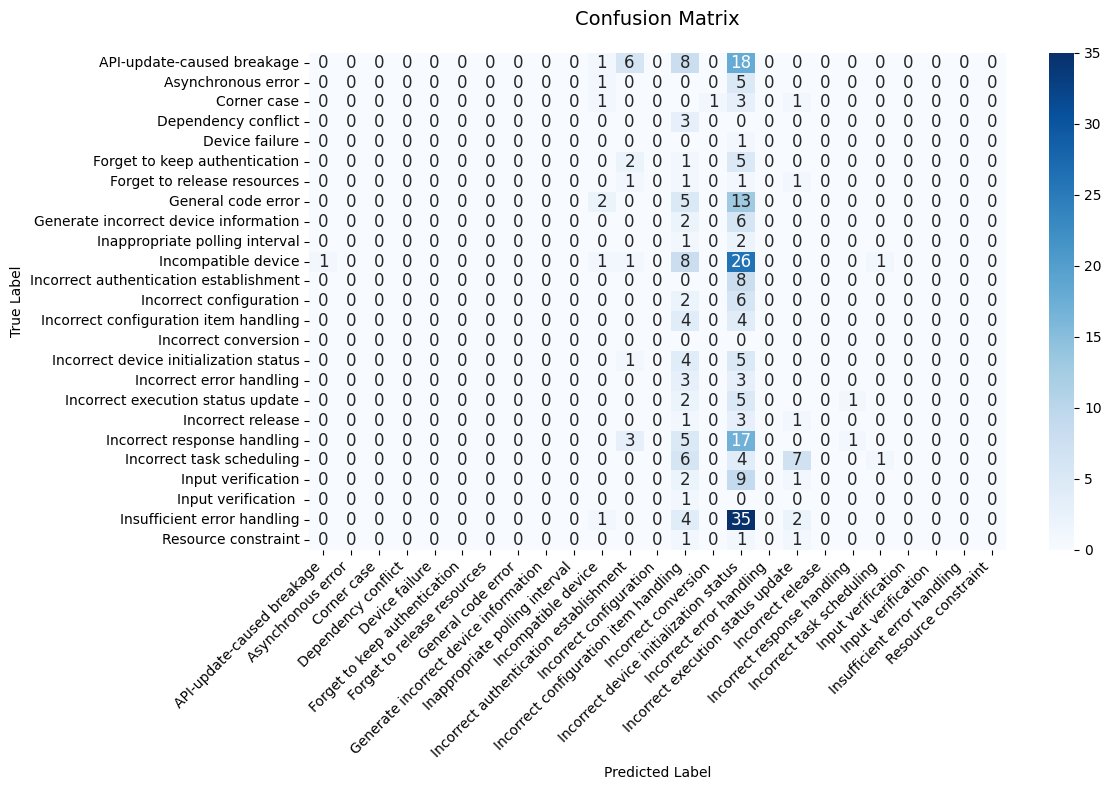

In [3]:
from metrics import plot_confusion_matrix

plot_confusion_matrix(metrics.confusion_matrix())
# metrics.plot_confusion_matrix()

# Llama

In [ ]:
!pip3 install transformers
!pip3 install accelerate
!pip3 install -U bitsandbytes

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
model_name = "meta-llama/Llama-2-7b-chat-hf"

llama_access_token=userdata.get('llama_API_KEY')

# model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto")
# bnb_config = BitsAndBytesConfig(
# load_in_4bit=True,
# bnb_4bit_use_double_quant=True,
# bnb_4bit_quant_type="nf4",
# bnb_4bit_compute_dtype=torch.bfloat16
# )
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             device_map="auto",
                                             token=llama_access_token,
                                            #  quantization_config=bnb_config,
                                             load_in_4bit=True,
                                             bnb_4bit_use_double_quant=True,
                                             bnb_4bit_quant_type="nf4",
                                             bnb_4bit_compute_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, token=llama_access_token)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
desc = merged_df['Title'][0] + merged_df['Body'][0]

llama_template = f"""<s>[INST] <<SYS>>\nYou are a root cause classifier.
    Here is the list of possible root causes:
    {merged_df['Root Cause'].unique().tolist()}\nFor the following issue description, classify it into one of the root cause.
    OUTPUT JUST THE ROOT CAUSE without any explanation in the following format.<</SYS>>
    Issue Description:
    {desc}[/INST]"""

In [ ]:
model_inputs = tokenizer(llama_template, return_tensors="pt").to("cuda:0")

output = model.generate(**model_inputs)
string = str(tokenizer.decode(output[0][len(model_inputs['input_ids'][0]) - len(output[0]):], skip_special_tokens=True))
print(string.removeprefix(llama_template))

 Based on the information provided, the root cause of the issue is:

* Incorrect task scheduling


In [ ]:
def check_rootcause_llama(desc):
  llama_template = f"""<s>[INST] <<SYS>>\nYou are a root cause classifier.
  Here is the list of possible root causes:
  {merged_df['Root Cause'].unique().tolist()}\nFor the following issue description, classify it into one of the root cause.
  Output ONLY the one possible predicted root cause without any explanation.<</SYS>>
  Issue Description:
  {desc}[/INST]"""

  model_inputs = tokenizer(llama_template, return_tensors="pt").to("cuda:0")

  output = model.generate(**model_inputs)

  return str(tokenizer.decode(output[0][len(model_inputs['input_ids'][0]) - len(output[0]):], skip_special_tokens=True))

In [ ]:
i = 20
check_rootcause_llama(merged_df['Title'][i] + merged_df['Body'][i])

' Based on the information provided, the most likely root cause of the issue is:\n\n* Incorrect configuration item handling\n\nThe error message "User input malformed" suggests that there is an issue with the way the configuration item is being handled, possibly due to a mismatch between the expected format of the input and the actual input provided. The mention of the [get operator](https://docs.python.org/3/library/types.html#types.MappingProxyType.get) in the configuration flow code and the lack of a default value for the Precision property suggest that there may be a problem with how the configuration item is being retrieved or processed.'

In [ ]:
true_rootcause_list_llama = []
pred_rootcause_list_llama = []
i = 0
k = 0
while i < len(merged_df):
  print(i)
  try:
    pred_rootcause = check_rootcause_llama(merged_df['Title'][i] + merged_df['Body'][i])
    true_rootcause = merged_df['Root Cause'][i]

    pred_rootcause_list_llama.append(pred_rootcause)
    true_rootcause_list_llama.append(true_rootcause)

    # time.sleep(3)

    print(f"Predicted Root Cause: {pred_rootcause}, True Root Cause: {true_rootcause}")
    i += 1
    k = 0

  except:
    k += 1
    if k == 3:
      i += 1
    print("Error")

0
Predicted Root Cause:  Based on the information provided, the predicted root cause of the issue is:

* Incorrect task scheduling, True Root Cause: Incorrect task scheduling
1
Predicted Root Cause:  Root cause: Incorrect device initialization status, True Root Cause: Generate incorrect device information
2
Predicted Root Cause:  Based on the information provided, the most likely root cause of the issue is:

* Incorrect device initialization status

This is because the error message suggests that the binary sensor is unable to retrieve the latest data from the Notion API, which could be due to an issue with the device initialization status. The error message also mentions a "KeyError: 'value'", which suggests that the issue may be related to the way the binary sensor is trying to access the Notion data., True Root Cause: API-update-caused breakage
3
Error
3
Error
3
Error
4
Predicted Root Cause:  Based on the information provided, the most likely root cause of the issue is:

* Incorrect

In [ ]:
import pickle

# my_list = [1, 2, 3, "hello"]

# Save the list to a file
with open("llama_pred.pkl", "wb") as f:
    pickle.dump(pred_rootcause_list_llama, f)

with open("llama_true.pkl", "wb") as f:
    pickle.dump(true_rootcause_list_llama, f)

# Load the list from the file
# with open("my_list.pkl", "rb") as f:
#     loaded_list = pickle.load(f)

In [ ]:
import pickle
with open("/content/llama_pred.pkl", "rb") as f:
    llama_pred = pickle.load(f)

In [ ]:
import pickle
with open("/content/llama_true.pkl", "rb") as f:
    llama_true = pickle.load(f)
len(llama_true)

323

In [ ]:
llama_pred[0]

' Based on the information provided, the predicted root cause of the issue is:\n\n* Incorrect task scheduling'

In [ ]:
extracted_pred_llamma = []
final_true_llama = []

n = 0
for j in range(len(llama_pred)):
  extracted = None
  n += 1
  for i in merged_df['Root Cause'].unique().tolist():
    if i in llama_pred[j]:
      extracted = i
      extracted_pred_llamma.append(extracted)
      final_true_llama.append(llama_true[j])
      break
  if extracted is None:
    print("n = ", n)
    print("-"*5, llama_pred[j])
  # print(extracted)


n =  14
-----  Root cause: Incorrect initialization status
n =  22
-----  Based on the information provided, the most likely root cause of the issue is:

* 'Incorrect module naming'

The error message suggests that the module 'georss_client.generic_feed' is not found, which could be caused by a naming conflict or incorrect module installation.
n =  24
-----  Based on the information provided, the most likely root cause of the issue is:

* Incorrect device information

The error message "Cannot update devices: 404" suggests that Home Assistant is unable to find the Somfy devices in the Somfy API. This could be due to incorrect device information in the `configuration.yaml` file, such as the `client_id` and `client_secret` not matching the actual values in the Somfy API.
n =  28
-----  Root cause: Incorrect initialization of hardware state on startup.
n =  29
-----  Based on the information provided, the possible root cause of the issue is:

* Incorrect device information

This root caus

In [ ]:
len(extracted_pred_llamma)

284

In [ ]:
len(final_true_llama)

284


Classification Report:
                                        precision    recall  f1-score   support

            API-update-caused breakage       0.29      0.11      0.16        35
                    Asynchronous error       0.00      0.00      0.00         6
                           Corner case       0.00      0.00      0.00         3
                   Dependency conflict       0.00      0.00      0.00         3
         Forget to keep authentication       0.00      0.00      0.00         8
           Forget to release resources       0.00      0.00      0.00         3
                    General code error       0.00      0.00      0.00        20
 Generate incorrect device information       0.00      0.00      0.00         7
        Inappropriate polling interval       0.00      0.00      0.00         3
                   Incompatible device       0.10      0.03      0.04        40
Incorrect authentication establishment       0.19      0.44      0.27         9
               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


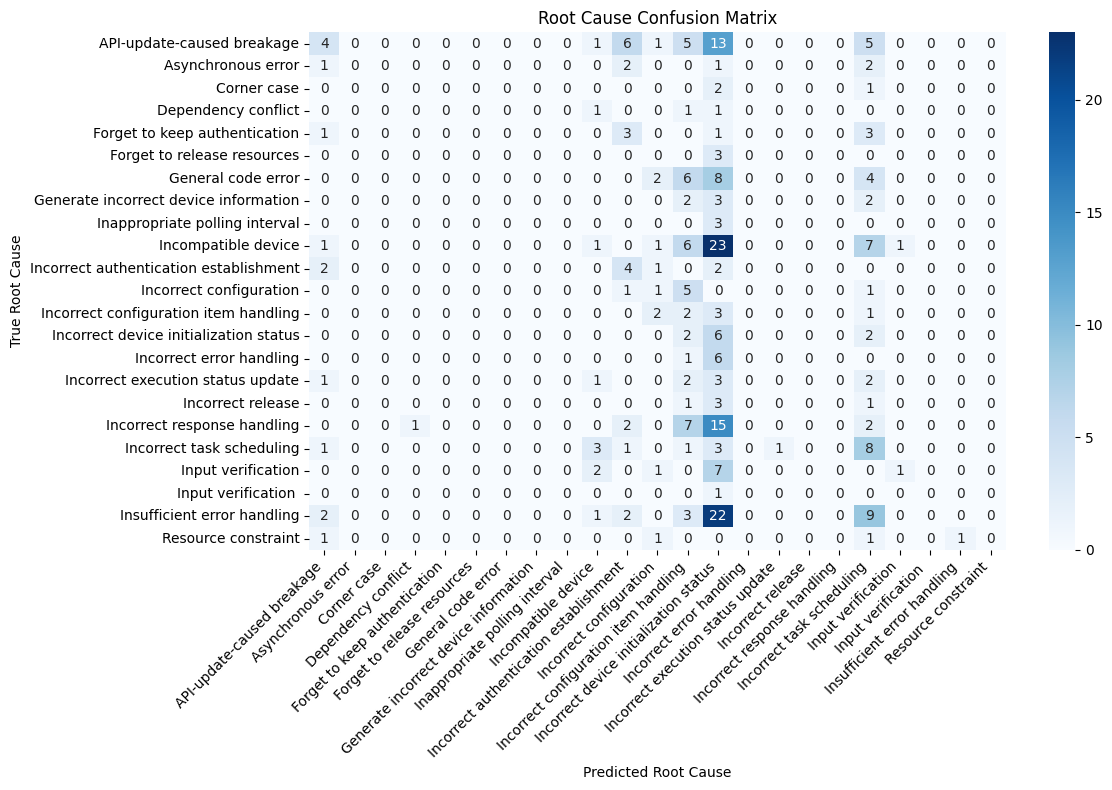

In [ ]:
confusion_matrix = generate_confusion_matrix(final_true_llama, extracted_pred_llamma)

# ChatGPT

In [22]:
import os
from openai import OpenAI

client = OpenAI(
    # api_key=os.environ.get("OPENAI_API_KEY"),  # This is the default and can be omitted
    api_key=userdata.get("GPT_API_KEY")
)
print(client.models.list())

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o-mini",
)

chat_completion.choices[0].message.content

SyncPage[Model](data=[Model(id='gpt-4-1106-preview', created=1698957206, object='model', owned_by='system'), Model(id='o1-preview', created=1725648897, object='model', owned_by='system'), Model(id='gpt-4', created=1687882411, object='model', owned_by='openai'), Model(id='o1-preview-2024-09-12', created=1725648865, object='model', owned_by='system'), Model(id='o1-mini-2024-09-12', created=1725648979, object='model', owned_by='system'), Model(id='o1-mini', created=1725649008, object='model', owned_by='system'), Model(id='dall-e-2', created=1698798177, object='model', owned_by='system'), Model(id='gpt-4o-mini-2024-07-18', created=1721172717, object='model', owned_by='system'), Model(id='gpt-4o-mini', created=1721172741, object='model', owned_by='system'), Model(id='gpt-3.5-turbo', created=1677610602, object='model', owned_by='openai'), Model(id='gpt-3.5-turbo-0125', created=1706048358, object='model', owned_by='system'), Model(id='babbage-002', created=1692634615, object='model', owned_by

'This is a test. How can I assist you further?'

In [23]:
def check_rootcause_gpt(desc):
    system_message = f"""
    Task Description: For the following issue description, identify the root cause from the possible root causes.
    Possible Root Causes: {merged_df['Root Cause'].unique().tolist()}
    OUTPUT JUST THE ROOT CAUSE.

    Examples:
    Input Issue Description: {random_rows.iloc[0]['Title'] + random_rows.iloc[0]['Body']}
    Output: {random_rows.iloc[0]['Root Cause']}

    Input Issue Description: {random_rows.iloc[1]['Title'] + random_rows.iloc[1]['Body']}
    Output: {random_rows.iloc[1]['Root Cause']}

    Input Issue Description: {random_rows.iloc[2]['Title'] + random_rows.iloc[2]['Body']}
    Output: {random_rows.iloc[2]['Root Cause']}

    Now it's your turn:
    Input Issue Description: {desc}
    Output:
    """

    chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "user",
              "content": system_message,
          }
      ],
      model="gpt-4o-mini",
    )
    return chat_completion.choices[0].message.content

In [24]:
check_rootcause_gpt(merged_df['Title'][2] + merged_df['Body'][2])

'Incorrect response handling'

In [25]:
merged_df['Root Cause'][2]

'API-update-caused breakage'

In [26]:
gpt_true_rootcause_list = []
gpt_pred_rootcause_list = []
i = 0
k = 0
while i < len(merged_df):
  print(i)
  try:
    pred_rootcause = check_rootcause_gpt(merged_df['Title'][i] + merged_df['Body'][i])
    true_rootcause = merged_df['Root Cause'][i]

    gpt_pred_rootcause_list.append(pred_rootcause)
    gpt_true_rootcause_list.append(true_rootcause)

    # time.sleep(3)

    print(f"Predicted Root Cause: {pred_rootcause}, True Root Cause: {true_rootcause}")
    i += 1
    k = 0

  except:
    k += 1
    if k == 3:
      i += 1
    print("Error")

0
Predicted Root Cause: Asynchronous error, True Root Cause: Incorrect task scheduling
1
Predicted Root Cause: Device failure, True Root Cause: Generate incorrect device information
2
Predicted Root Cause: Incorrect response handling, True Root Cause: API-update-caused breakage
3
Predicted Root Cause: Asynchronous error, True Root Cause: Device failure
4
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Forget to keep authentication
5
Predicted Root Cause: Incorrect authentication establishment, True Root Cause: Input verification
6
Predicted Root Cause: Incorrect execution status update, True Root Cause: Incompatible device
7
Predicted Root Cause: Incorrect response handling, True Root Cause: API-update-caused breakage
8
Predicted Root Cause: Incorrect response handling, True Root Cause: Insufficient error handling
9
Predicted Root Cause: API-update-caused breakage, True Root Cause: Input verification
10
Predicted Root Cause: Incorrect response handling, T

In [27]:
print(len(gpt_pred_rootcause_list))
print(len(gpt_true_rootcause_list))

330
330


In [28]:
import pickle

# Save the list to a file
with open("gpt_pred_3shot.pkl", "wb") as f:
    pickle.dump(gpt_pred_rootcause_list, f)

with open("gpt_true_3shot.pkl", "wb") as f:
    pickle.dump(gpt_true_rootcause_list, f)

In [29]:
import pickle

# Load the list from the file
with open("/content/gpt_pred_3shot.pkl", "rb") as f:
    gpt_pred_rootcause_list = pickle.load(f)

with open("/content/gpt_true_3shot.pkl", "rb") as f:
    gpt_true_rootcause_list = pickle.load(f)

In [30]:
from metrics import MultiClassMetrics

metrics = MultiClassMetrics(gpt_true_rootcause_list, gpt_pred_rootcause_list)

# Print summary
print("Summary Metrics:")
for metric, value in metrics.summary().items():
    print(f"{metric}: {value:.3f}")

print("\nPer-class metrics:")
for class_label, class_metrics in metrics.per_class_metrics().items():
    print(f"\n{class_label}:")
    for metric_name, value in class_metrics.items():
        print(f"  {metric_name}: {value:.3f}")

print("\nConfusion Matrix:")
print(metrics.confusion_matrix())

print("\nDetailed Classification Report:")
print(metrics.class_report())

Summary Metrics:
accuracy: 0.152
macro_precision: 0.092
macro_recall: 0.129
macro_f1: 0.083
kappa: 0.102

Per-class metrics:

API-update-caused breakage:
  precision: 0.379
  recall: 0.289
  f1: 0.328

Asynchronous error:
  precision: 0.074
  recall: 0.286
  f1: 0.118

Corner case:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Dependency conflict:
  precision: 0.200
  recall: 0.333
  f1: 0.250

Device failure:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Forget to keep authentication:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Forget to release resources:
  precision: 0.000
  recall: 0.000
  f1: 0.000

General code error:
  precision: 0.167
  recall: 0.040
  f1: 0.065

Generate incorrect device information:
  precision: 0.000
  recall: 0.000
  f1: 0.000

Inappropriate polling interval:
  precision: 0.333
  recall: 0.667
  f1: 0.444

Incompatible device:
  precision: 0.600
  recall: 0.067
  f1: 0.120

Incorrect authentication establishment:
  precision: 0.250
  recall: 0.583
 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

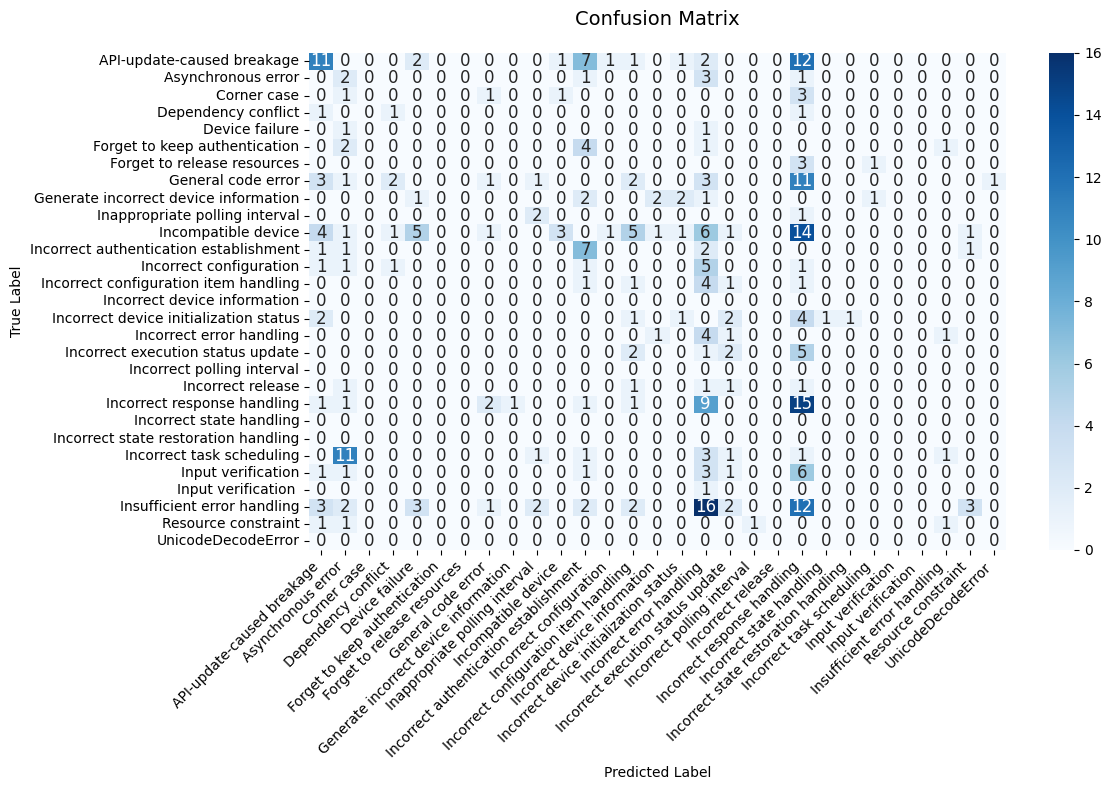

In [31]:
from metrics import plot_confusion_matrix

plot_confusion_matrix(metrics.confusion_matrix())